# Analysing SARS-CoV-2 outbreak in Italy with controlled SIR model

The controlled-SIR model describes how regulatory and societal reactions impact the dynamics of a disease reproduction rate. Recent [paper](https://arxiv.org/abs/2004.00493) presents an analytic solution to the controlled-SIR models described as

\begin{equation}
\begin{split}
\tau \dot{S} & = -g S I\\
\tau \dot{I} & = \left(gS - 1\right)I\\
\tau \dot{R} & = I
\end{split}
\end{equation}
where we denote with S = S(t) the fraction of susceptible (non-affected) individuals, with I = I(t) the fraction of the population that is currently ill (active cases), and with R = R(t) the fraction of recovered or deceased individuals. At all times the following relation holds $S+R+I=1$. 

Unlike the standard SIR model in the controlled version the dissease reproduction rate g, is a function of 
the active cases $I$ and the total cases $X=1-S = I + R$

\begin{equation}
g = \frac{g_0}{1 + \alpha_X X + \alpha_I I}
\end{equation}

Given the differential equations for $X$ and $I$ we can obtain time derivative of $g$ as

$$ \tau \dot{g} = \partial_X g(X,I) \dot{X} + \partial_I g(X,I) \dot{I} $$.

Given that 

$$\partial_X g(X,I) = - \frac{\alpha_X}{g_0} g^2 $$

and

$$ \partial_I g(X, I) = - \frac{\alpha_I}{g_0} g^2$$

we get the following expression for $\dot{g}$

$$ \tau \dot{g} = \frac{\alpha g^2 I}{g_0}\left[\rho -  g (1 - X) \right]$$

where $\alpha = \alpha_X + \alpha_I$, and $\rho=\frac{\alpha_I}{\alpha}$. Assuming that the underlying quantities of interest are piecewise constant we can express the changes in $g$ as

$$ g(t+1) \approx \frac{g(t) g_0 \tau}{g_0 \tau - \alpha g(t) I(t) \left[\rho - g(t)(1-X(t)) \right]} $$

Similarly, integrating $\dot{I}$ we get the following approximate relationship 

$$ I(t + 1) \approx I(t) exp\left\{\frac{g(t)\cdot(1-X(t)) - 1}{\tau}\right\}$$

In [1]:
import jax.numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, nn
from jax.experimental.ode import odeint

from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import substitute, condition

sns.set(style='white', context='notebook', palette='muted')

In [2]:
def dz_dt(z, t, theta):
    """
    Controleld SIR equations for the case of dynamic control parameters.
    """
    X, I, R, g = z
    tau = theta['tau']
    alpha = theta['alpha']
    g0 = theta['g0']
    rho = nn.sigmoid(theta['k'] * (t - theta['b']))
    
    dg_dt = alpha * np.power(g, 2) * I * (rho - g * (1 - X))/ (tau * g0)
    dX_dt = g * (1 - X) * I/tau 
    dI_dt = (g * (1 - X) - 1) * I/tau
    dR_dt = I/tau
    return np.stack([dX_dt, dI_dt, dR_dt, dg_dt])

Integrating the contolled SIR model with fixed control parameters
\begin{equation}
\begin{split}
\tau \dot{S} & = -g(I,S) S I\\
\tau \dot{I} & = \left(g(I,S)S - 1\right)I\\
\tau \dot{R} & = I \\
g &= \frac{g_0}{1 + \alpha_X X + \alpha_I I}
\end{split}
\end{equation}
results in the following solution 

$$ I = \frac{g_0 + \alpha_X}{g_0 - \alpha_I} X + \left(\frac{g_0 + \alpha_X}{g_0 - \alpha_I} + \frac{1 + \alpha_X}{\alpha_I} \right) \left[ (1 - X)^{\alpha_I/g_0} - 1\right] $$

We will integrate the SIR using an adaptive Runge-Kutta ODE integrator availible in the jax library, and compare it to the approximate difference equations, and the exact solution described above.

In [3]:
def fun_I(x, aX, aI, g0):
    par1 = (g0 + aX)/(g0 - aI)
    par2 = (1 + aX)/aI
    
    return par1 * x + (par1 + par2) * (np.exp(np.log(1 - x) * aI/g0) - 1)

In [4]:
T = 41
g0 = 1.5
alpha = 10.
ts = np.arange(0, float(T), 1.)
z_init = np.array([1e-5, 1e-5, 0., g0])
theta = {'tau': 1. * np.ones(1),
         'alpha': 0. * np.ones(1),
         'g0': g0 * np.ones(1),
         'k': 10. * np.ones(1),
         'b': np.ones(1)}

z0_0 = odeint(dz_dt, z_init, ts, theta, rtol=1e-14, atol=1e-12, mxstep=2000)

theta['alpha'] = 2 * alpha * np.ones(1)
theta['b'] = -1000. * np.ones(1)
z_init = np.array([z_init[0], z_init[1], 0., g0/(1 + alpha * z_init[1])])
z0_10 = odeint(dz_dt, z_init, ts, theta, rtol=1e-14, atol=1e-12, mxstep=2000)

theta['alpha'] = alpha * np.ones(1)
theta['k'] = .0 * np.ones(1)
z5_5 = odeint(dz_dt, z_init, ts, theta, rtol=1e-14, atol=1e-12, mxstep=2000)

theta['k'] = 10 * np.ones(1)
theta['b'] = 1000. * np.ones(1)
z10_0 = odeint(dz_dt, z_init, ts, theta, rtol=1e-14, atol=1e-12, mxstep=2000)

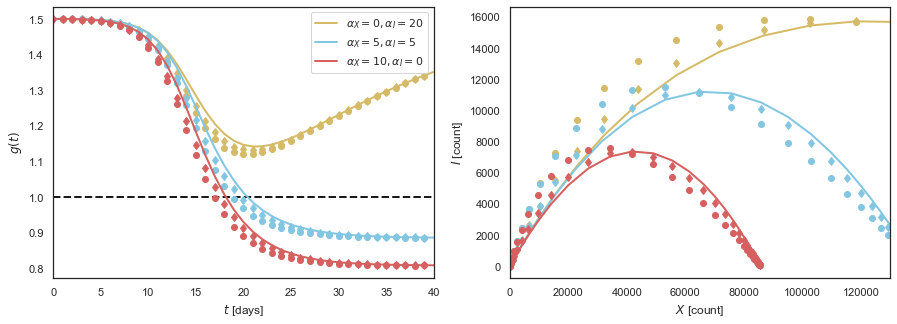

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
N = 1e6

axes[0].plot(ts, z0_10[:, -1], 'y-', lw=2, label=r'$\alpha_X = 0, \alpha_I=20$');
axes[0].plot(ts[:-1], (np.diff(np.log(z0_10[:, 1])) * theta['tau'] + 1)/(1-z0_10[:-1, 0]), 'yd', lw=2);
axes[0].plot(ts[1:-1], (np.diff(np.log(np.diff(z0_10[:, 0])))* theta['tau'] + 1)/(1-z0_10[1:-1, 0]), 'yo');

axes[1].plot(N * z0_10[:, 0],  N * z0_10[:, 1], 'y-', lw=2);
axes[1].plot(N * z0_10[:-1, 0],  N * np.diff(z0_10[:, 2], axis=0) * theta['tau'], 'yd', lw=3);
axes[1].plot(N * z0_10[:-1, 0], N * np.diff(z0_10[:, 0], axis=0) * theta['tau'], 'yo');

axes[0].plot(ts, z5_5[:, -1], 'c-', lw=2, label=r'$\alpha_X = 5, \alpha_I=5$');
axes[0].plot(ts[:-1], (np.diff(np.log(z5_5[:, 1]))* theta['tau'] + 1)/(1-z5_5[:-1, 0]), 'cd', lw=2);
axes[0].plot(ts[1:-1], (np.diff(np.log(np.diff(z5_5[:, 0])))* theta['tau'] + 1)/(1-z5_5[1:-1, 0]), 'co');

axes[1].plot(N * z5_5[:, 0],  N * z5_5[:, 1], 'c-', lw=2);
axes[1].plot(N * z5_5[:-1, 0],  N * np.diff(z5_5[:, 2], axis=0) * theta['tau'], 'cd', lw=3);
axes[1].plot(N * z5_5[:-1, 0], N * np.diff(z5_5[:, 0], axis=0) * theta['tau'], 'co');

axes[0].plot(ts, z10_0[:, -1], 'r-', lw=2, label=r'$\alpha_X = 10, \alpha_I=0$');
axes[0].plot(ts[:-1], (np.diff(np.log(z10_0[:, 1]))* theta['tau'] + 1)/(1-z10_0[:-1, 0]), 'rd', lw=3);
axes[0].plot(ts[1:-1], (np.diff(np.log(np.diff(z10_0[:, 0])))* theta['tau'] + 1)/(1-z10_0[1:-1, 0]), 'ro');

axes[1].plot(N * z10_0[1:, 0], N * z10_0[1:, 1], 'r-', lw=2);
axes[1].plot(N * z10_0[:-1, 0], N * np.diff(z10_0[:, 2], axis=0) * theta['tau'], 
             'rd', lw=3);

axes[1].plot(N * z10_0[:-1, 0], N * np.diff(z10_0[:, 0], axis=0) * theta['tau'], 
             'ro');

axes[0].hlines(1, 0, 40, 'k', linestyle='--', lw=2)
axes[0].legend();
axes[1].set_xlabel(r'$X$ [count]');
axes[1].set_ylabel(r'$I$ [count]')
# axes[1].set_ylabel(r'count');
axes[1].set_xlim([0, 130000])

axes[0].set_ylabel(r'$g(t)$');
axes[0].set_xlabel(r'$t$ [days]');
axes[0].set_xlim([0, 40]);

fig.savefig('comparison_recovery.pdf', bbox_inches='tight', transparent=True, dpi=300)

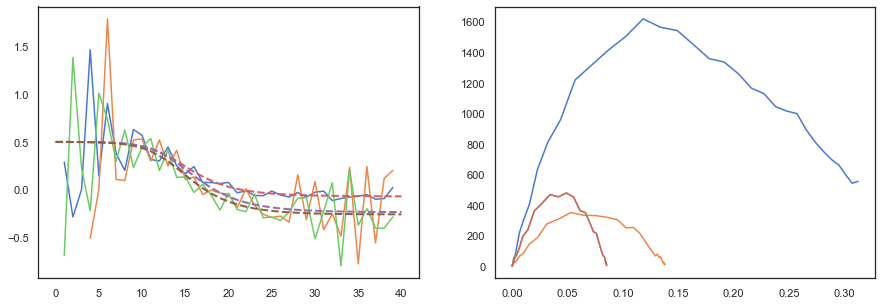

In [6]:
# generate test data
from scipy.stats import binom
import numpyro.distributions as dist
import numpy as onp

Is = np.stack([z0_10[:, 1], z5_5[:, 1], z10_0[:, 1]], -1)
gs = np.stack([z0_10[:, -1], z5_5[:, -1], z10_0[:, -1]], -1)
Xs = np.stack([z0_10[:, 0], z5_5[:, 0], z10_0[:, 0]], -1)
c = random.uniform(random.PRNGKey(0), shape=(3,))/10

rate = 1000.
dX = N * np.diff(Xs, axis=0)
mu = dX

dX_data = dist.GammaPoisson(mu * rate, rate).sample(random.PRNGKey(1))

mu = c * Is * N
dF_data = dist.Poisson(mu).sample(random.PRNGKey(1))
x_t = gs * (1-Xs) - 1

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(np.diff(np.log(dF_data), axis=0))
axes[0].plot(x_t, '--', lw=2)
for i in range(4):
    axes[1].plot(Xs[:, i], dF_data[:, i])

In [7]:
# implementation of the inference for XI relationship from daily fatalities

import numpyro as npyro
import numpyro.distributions as dist
from numpyro.distributions.transforms import ( 
    AffineTransform, 
    ExpTransform, 
    IdentityTransform, 
    ComposeTransform
)

from numpyro.distributions import constraints

from numpyro.contrib.reparam import TransformReparam, reparam

npyro.enable_validation(True)

def fun_g(X, I, aX, aI, g0):
    return g0/(1 + aX * X + aI * I)

def fun_I(x, kX, kI, g0):
    par1 = (1 + kX)/ (1 - kI)
    par2 = 1./(g0 * kI) + kX / kI
    
    return par1 * x + (par1 + par2) * (np.power(1 - x, kI) - 1)

def model(data, obs=None):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, I, D
    :param numpy.ndarray obs: 
    """
    
    # infer the fraction of the total population that can be infected. With this we also assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.

    X_data = data['X']
    dF_data = data['dF']
    N = data['N']
    kappa = data['kappa']
    
    T, K = X_data.shape
    
    s_hyp = np.array([2., 1.])
    
    k_I = npyro.param('k_I', np.ones(K) * 5., constraint=constraints.positive)
    k_X = npyro.param('k_X', np.ones(K) * 5., constraint=constraints.positive)
    
    with npyro.plate('countries', K):
        f = npyro.sample('f', dist.Gamma(2., 2.))
        norm = npyro.deterministic('nf', f * N)
        
        gamma = npyro.sample('gamma', dist.Gamma(10., 10.))
        g0 = npyro.sample('g0', dist.Gamma(3., 2.))
        
        n_X = X_data/norm

        n_I = fun_I(n_X, k_X, k_I, g0)
        npyro.deterministic('I', norm * np.where(n_I > 0., n_I, 0.))
        
        a_X = npyro.deterministic('a_X', g0 * k_X)
        a_I = npyro.deterministic('a_I', g0 * k_I)
    
        g_t = npyro.deterministic('g_t', fun_g(n_X, n_I, a_X, a_I, g0))
        
        dF = npyro.deterministic('dF', norm * n_I / kappa)
        
        scale1 = npyro.sample('scale1', dist.InverseGamma(2., 1.))
        scale2 = npyro.sample('scale2', dist.InverseGamma(2., 1.))
        
        npyro.deterministic('tau', 1/gamma)
        npyro.deterministic('p', gamma/kappa)
        
        x_t = npyro.deterministic('x_t', gamma * (g_t * (1-n_X) - 1))
        with npyro.plate('data_1', T-1):
            dist1 = dist.StudentT(10., 0., 1.)
            aff1 = AffineTransform(x_t[:-1], np.sqrt(scale1))
            trans_dist1 = dist.TransformedDistribution(dist1, aff1)
            npyro.sample("obs1", trans_dist1.mask(data['mask_1']), obs=obs)
            
        with npyro.plate('data_2', T):
            dist2 = dist.StudentT(2., 0., 1.)
            aff2 = AffineTransform(dF, np.sqrt(scale2))
            trans_dist2 = dist.TransformedDistribution(dist2, aff2)
            npyro.sample("obs2", trans_dist2.mask(data['mask_2']), obs=dF_data)

In [8]:
dX_data = np.where(dX_data > 0., dX_data, 0.)
X = np.concatenate([Xs[:1] * N, dX_data], 0).cumsum(0)

dF_data = np.where(dF_data > 0., dF_data, 0.)

obs = np.log(dF_data[1:]) - np.log(dF_data[:-1])
obs = np.where(np.isposinf(obs), np.nan, obs)
obs = np.where(np.isneginf(obs), np.nan, obs)
mask_1 = ~np.isnan(obs)
obs = np.nan_to_num(obs)


mask_2 = dF_data > 1.

kappa = (Xs[0] + dX_data.cumsum(0))[-1]/dF_data.cumsum(0)[-1]

data = {
    'N': np.ones(3) * N,
    'mask_1': mask_1,
    'mask_2': mask_2,
    'kappa': kappa,
    'X': X,
    'dF': dF_data
}

print('kappa: ', kappa)
print('1/c: ', 1/c)

kappa:  [10.395643 32.054337 15.536732]
1/c:  [10.359243 31.778149 15.797041]


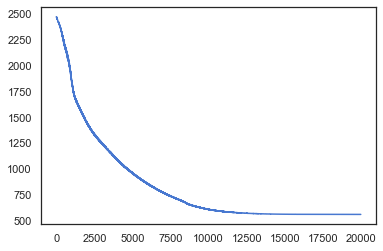

In [18]:
from numpyro import optim
from numpyro.infer import SVI, ELBO
from jax import random, lax

from numpyro.contrib.autoguide import AutoMultivariateNormal, AutoLaplaceApproximation, AutoContinuousELBO

# variational inference with approximate posterior
num_iters = 20000
num_samples = 1000

cmodel = condition(model, {'f': 1.})
# guide = AutoLaplaceApproximation(cmodel)
guide = AutoMultivariateNormal(cmodel)

svi = SVI(cmodel, guide, optim.Adam(0.0005), AutoContinuousELBO(num_particles=500))
svi_state = svi.init(random.PRNGKey(10101), data, obs=obs)

last_state, losses = lax.scan(lambda state, i: svi.update(state, data, obs=obs), 
                              svi_state, 
                              np.zeros(num_iters))

params = svi.get_params(last_state)
guide_sample = guide.sample_posterior(random.PRNGKey(0), params, sample_shape=(num_samples,))

return_sites = ['a_X', 'a_I', 'g0', 'g_t', 'tau', 'p', 'x_t', 'dF', 'I']
predict = Predictive(cmodel, 
                     guide=guide, 
                     posterior_samples=guide_sample, 
                     params=params, 
                     num_samples=num_samples, 
                     return_sites=return_sites)
sample = predict(random.PRNGKey(0), data, obs=obs)
plt.plot(losses)

In [20]:
print(params['k_X'], params['k_I'])

[0.01093392 3.1446257  6.8496637 ] [12.83944    3.060769   1.5869153]


Text(0.5, 0, 'true value')

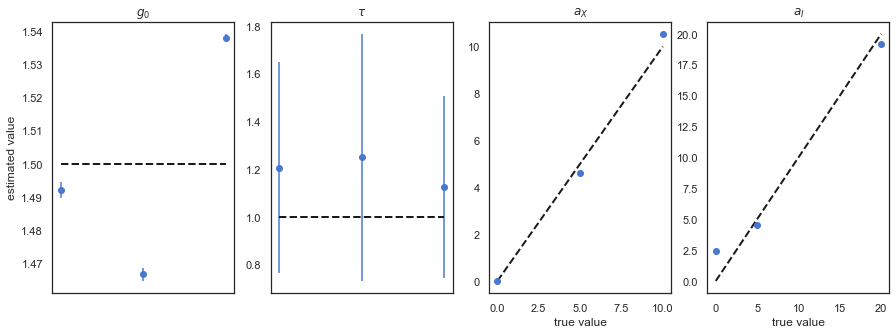

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].errorbar(range(3), sample['g0'].mean(0), 
                 yerr=2*sample['g0'].std(0), linestyle='', marker='o')
axes[0].hlines(1.5, 0, 2., 'k', lw=2, linestyle='--')
axes[0].set_title(r'$g_0$');
axes[0].set_xticklabels([])
axes[0].set_ylabel('estimated value')

axes[1].errorbar(range(3), sample['tau'].mean(0), 
                 yerr=2*sample['tau'].std(0), linestyle='', marker='o')
axes[1].hlines(1., 0, 2., 'k', lw=2, linestyle='--')
axes[1].set_title(r'$\tau$');
axes[1].set_xticklabels([])

axes[2].errorbar([.0, 5., 10.], sample['a_X'].mean(0), yerr=2*sample['a_X'].std(0), marker='o', linestyle='')
axes[2].plot([0,10], [0,10], 'k--', lw=2)
axes[2].set_title(r'$a_X$');
axes[2].set_xlabel('true value')

axes[3].errorbar([20., 5., 0.], sample['a_I'].mean(0), yerr=2*sample['a_I'].std(0), marker='o', linestyle='')
axes[3].plot([0,20], [0,20], 'k--', lw=2)
axes[3].set_title(r'$a_I$');
axes[3].set_xlabel('true value')

In the first two figures starting from the left we posterior estimates for $g_0$ and $\tau$ relative to the true value shown with dashed line. Note that each dots corresponds to different $\alpha_I, \alpha_X$ pair. The last two plots show the comparison of true value (used in simulation) to the posterior estimates. Note that closer the posterior expectation is to the dashed line the better the parameter recovery is. 

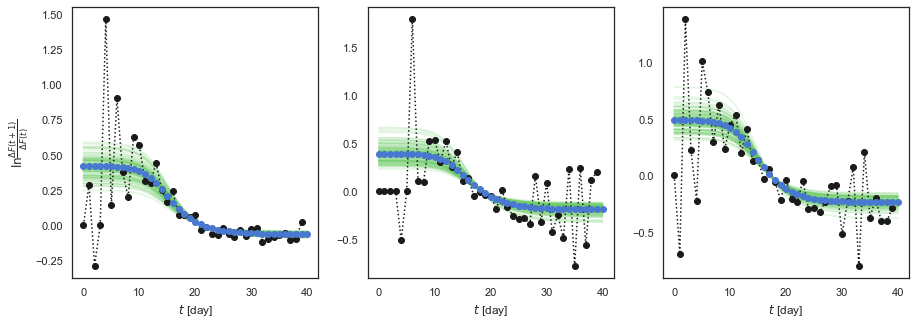

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

post_x_t = sample['x_t']
for i in range(3):
    axes[i].plot(post_x_t.mean(0)[:, i], 'bo', lw=3, zorder=10)
    axes[i].plot(post_x_t[:100, :, i].T, 'g-', alpha=.2)
    axes[i].plot(obs[:, i], 'ko:')
    axes[i].set_xlabel(r'$t$ [day]')

axes[0].set_ylabel(r'$\ln \frac{\Delta F(t+1) }{\Delta F(t)}$');

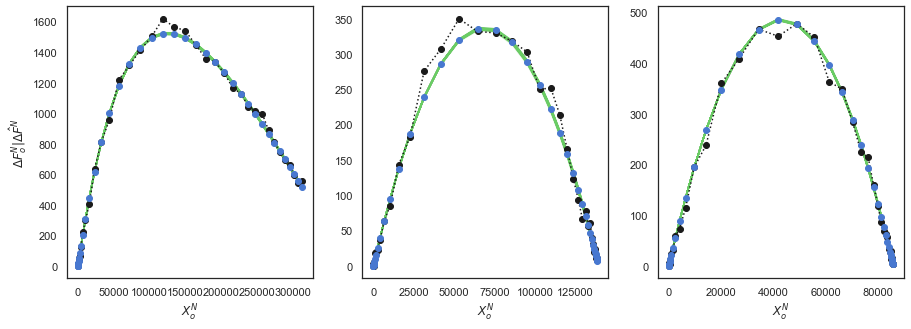

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

post_dF = sample['dF']
for i in range(3):
    axes[i].plot(data['X'][:, i], post_dF.mean(0)[:, i], 'bo', lw=3, zorder=10)
    axes[i].plot(data['X'][:, i], post_dF[:100, :, i].T, 'g-', alpha=.2)
    axes[i].plot(data['X'][:, i], data['dF'][:, i], 'ko:')
    axes[i].set_xlabel(r'$X^N_o$');
                       
axes[0].set_ylabel(r'$\Delta F^N_o|\Delta \hat{F}^N$');

Besides the static $IX$ relation plotted above we can also consider the dynamic case in which we smoothly transition between the long and short term control regime. For that we will consider the following form of the infection rate 

$$g = \frac{g_0}{1 + \alpha \cdot (1-\rho(t)) \cdot X + \alpha \rho(t) \cdot I} $$

where 

$$ \rho(t) = \frac{1}{1 + e^{- \kappa \cdot ( t - \beta)}}$$

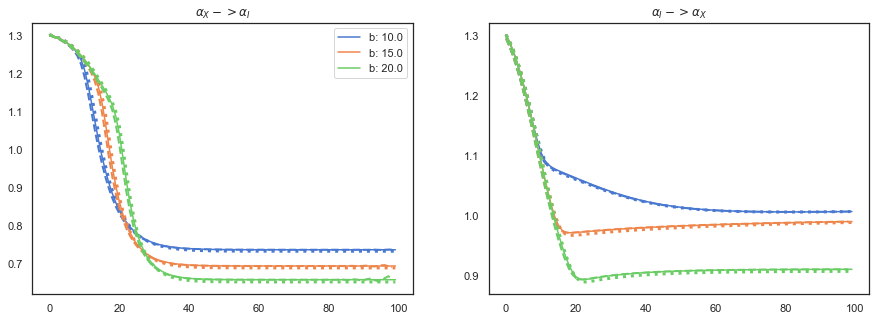

In [5]:
from jax import lax

def g_trans(carry, z):
    
    g, pars = carry
    
    X, I, rho = z
    
    alpha, tau, g0 = pars
    
    A = alpha * I * (rho - g * (1 - X)) / (g0 * tau)
    
    g_new = g /(1 - g * A)
    
    return (g_new, pars), g_new 

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
T = 100
ts = np.arange(0, float(T), 1.)
g0 = 1.3
z_init = np.array([1e-5, 1e-5, 0., g0])
theta['g0'] = g0
theta['alpha'] = 1000.
theta['tau'] = 1.5 * np.ones(1)
for b in [10., 15., 20.]:
    for i, k in enumerate([-1., 1.]):
        theta['b'] = b * np.ones(1)
        theta['k'] = k * np.ones(1)
        z = odeint(dz_dt, z_init, ts, theta, rtol=1e-12, atol=1e-10, mxstep=10000)
        base_line, = axes[i].plot(z[:, -1], label='b: {}'.format(b))
        
        hat_g = (theta['tau'] * (np.log(z[1:, 1]) - np.log(z[:-1, 1])) + 1)/(1 - z[:-1, 0])
        axes[i].plot(hat_g, '--', c=base_line.get_color(), lw=2)
        
        rho = nn.sigmoid(theta['k'] * (ts - theta['b']))
        varbs = (z[:, 0], z[:, 1], rho)
        pars = (theta['alpha'], theta['tau'][0], g0)
        _, int_g = lax.scan(g_trans, (g0, pars), varbs)
        int_g = np.concatenate([np.array([g0]), int_g])[:-1]
        axes[i].plot(int_g, ':', c=base_line.get_color(), lw=3)
    
axes[0].legend();
axes[0].set_title(r'$\alpha_X -> \alpha_I$');
axes[1].set_title(r'$\alpha_I -> \alpha_X$');